# AMLT Lab#2

## Table of content

- [AMLT Lab#2](#AMLT-Lab2)
  - [Table of content](#table-of-content)
  - [Imports](#imports)
  - [Data](#data)
  - [Models](#models)
  - [Evaluation](#evaluation)
  - [Results](#results)

## Imports

In [1]:
import shap
import lime
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

d:\Miniforge3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from prettytable import PrettyTable
from catboost import CatBoostClassifier
from eli5.sklearn import PermutationImportance

## Data

In [3]:
# https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download
data = pd.read_csv("wine.csv")
label_mapping = {'good': 1, 'bad': 0}
data['Quality'] = data['Quality'].replace(label_mapping)
data.head(10)

,Quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,1,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
5,0,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4
6,0,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4
7,1,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0
8,1,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5
9,0,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5


In [4]:
y = data['Quality']
X = data.drop('Quality', axis=1)
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.7, random_state=42)

## Model

### Simple Classifiers

In [5]:
knn_model = sklearn.neighbors.KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

svm_model = sklearn.svm.SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

dtc_model = sklearn.tree.DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)
dtc_pred = dtc_model.predict(X_test)

### Catboost classifier

In [6]:
cb_model= CatBoostClassifier(iterations=1000, learning_rate=0.3)
cb_model.fit(X_train, y_train,eval_set=(X_test, y_test), logging_level='Silent')
cb_pred = cb_model.predict(X_test)

## Evaluation

In [7]:
perm_knn = PermutationImportance(knn_model, random_state=42).fit(X_test, y_test)
perm_svm = PermutationImportance(svm_model, random_state=42).fit(X_test, y_test)
perm_dtc = PermutationImportance(dtc_model, random_state=42).fit(X_test, y_test)
perm_cb = PermutationImportance(cb_model, random_state=42).fit(X_test, y_test)

In [16]:
eli5_tab = PrettyTable()
eli5_tab.field_names = ["Feature", "kNN", "Support Vector Machines", "Decision Tree", "Catboost"]
names = ['alcohol', 'sulphates', 'volatile acidity', 'total sulfur dioxide', 'density', 'chlorides', 'citric acid', 'fixed acidity', 'free sulfur dioxide', 'pH', 'residual sugar']
for inx, val in enumerate(perm_knn.feature_importances_):
    eli5_tab.add_row([names[inx], val, perm_svm.feature_importances_[inx], perm_dtc.feature_importances_[inx], perm_cb.feature_importances_[inx]])

print(eli5_tab)

+----------------------+----------------------+-------------------------+----------------------+----------------------+
|       Feature        |         kNN          | Support Vector Machines |    Decision Tree     |       Catboost       |
+----------------------+----------------------+-------------------------+----------------------+----------------------+
|       alcohol        | 0.020833333333333304 |   0.016250000000000032  | 0.042916666666666735 | 0.02791666666666668  |
|      sulphates       | 0.017916666666666626 |   0.02791666666666668   | 0.04541666666666668  | 0.05125000000000004  |
|   volatile acidity   | 0.013749999999999974 |   0.008333333333333304  | 0.03166666666666669  | 0.017916666666666692 |
| total sulfur dioxide | 0.004166666666666629 |   0.004583333333333317  | 0.004583333333333361 | 0.021666666666666702 |
|       density        | 0.009999999999999986 |  0.0008333333333333304  | 0.03208333333333335  | 0.01916666666666671  |
|      chlorides       | 0.0174999999999

In [10]:
rez_tab = PrettyTable()
rez_tab.field_names = ["Model", "ACC", "F1", "Precision", "Recall"]
rez_tab.add_row(["kNN", knn_model.score(X_test, y_test), sklearn.metrics.f1_score(y_test, knn_pred), sklearn.metrics.precision_score(y_test, knn_pred), sklearn.metrics.recall_score(y_test, knn_pred)])
rez_tab.add_row(["Support Vector Machines", svm_model.score(X_test, y_test), sklearn.metrics.f1_score(y_test, svm_pred), sklearn.metrics.precision_score(y_test, svm_pred), sklearn.metrics.recall_score(y_test, svm_pred)])
rez_tab.add_row(["Decision Tree", dtc_model.score(X_test, y_test), sklearn.metrics.f1_score(y_test, dtc_pred), sklearn.metrics.precision_score(y_test, dtc_pred), sklearn.metrics.recall_score(y_test, dtc_pred)])
rez_tab.add_row(["Catboost", cb_model.score(X_test, y_test), sklearn.metrics.f1_score(y_test, cb_pred), sklearn.metrics.precision_score(y_test, cb_pred), sklearn.metrics.recall_score(y_test, cb_pred)])
print(rez_tab)

+-------------------------+--------------------+--------------------+--------------------+--------------------+
|          Model          |        ACC         |         F1         |     Precision      |       Recall       |
+-------------------------+--------------------+--------------------+--------------------+--------------------+
|           kNN           | 0.7270833333333333 | 0.761384335154827  | 0.7411347517730497 | 0.7827715355805244 |
| Support Vector Machines | 0.7479166666666667 | 0.7641325536062379 | 0.7967479674796748 | 0.7340823970037453 |
|      Decision Tree      | 0.7708333333333334 | 0.8007246376811593 | 0.775438596491228  | 0.8277153558052435 |
|         Catboost        | 0.8083333333333333 | 0.8270676691729324 | 0.8301886792452831 | 0.8239700374531835 |
+-------------------------+--------------------+--------------------+--------------------+--------------------+


## Results

### SHAP

In [11]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X)
shap.initjs()
waterfall_shap_values = explainer(X)
shap.plots.force(explainer.expected_value, shap_values[1], X[1], feature_names=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])

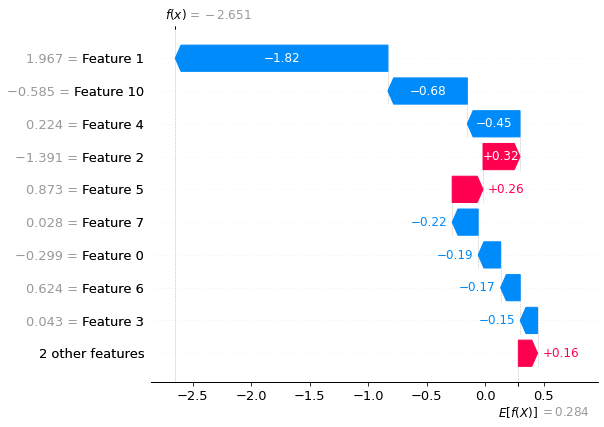

In [12]:
shap.plots.waterfall(waterfall_shap_values[1,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


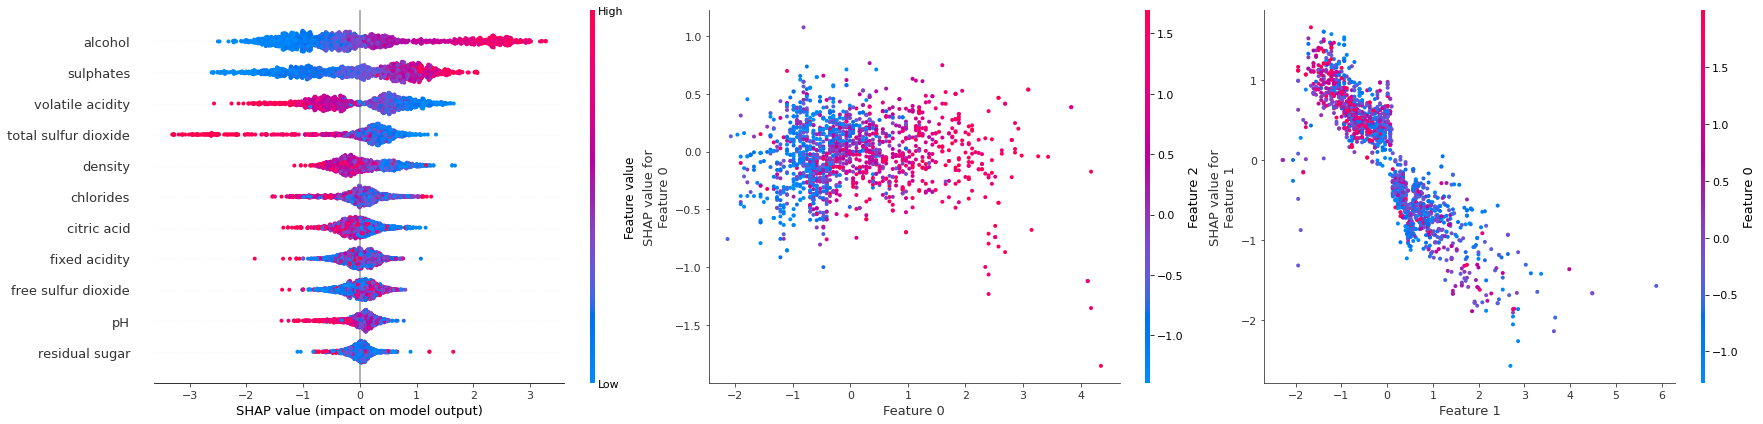

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
plt.subplot(131)
shap.summary_plot(shap_values, X, feature_names=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'], show=False, plot_size=None)
shap.dependence_plot("Feature 0", shap_values, X, ax=axes[1], show=False)
shap.dependence_plot("Feature 1", shap_values, X, ax=axes[2], show=False)
plt.show()

### LIME

In [15]:
lime_expl = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
                                                   class_names=[0, 1],
                                                   discretize_continuous=True)

cb_model.predict_proba(X_test[2])

exp = lime_expl.explain_instance(X_test[2], lambda x: cb_model.predict_proba(x))
exp.show_in_notebook(show_table=True)